### This will be in the prepare module
    _Check for and remove duplicates by customer_id. - None
    
    _Remove redundant columns: payment_type_id, internet_service_type_id, contract_type_id, & customer_id. - Completed
        -Used the following to drop redundant columns
        -df = df.drop(['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], axis = 1)
        -df.head(2)
    
    _Encode payment_type(Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)), internet_service_type(DSL, Fiber, None), contract_type(Month-to-month, One year, Two year), gender(male/female), partner(yes/no), multiple_line(yes/no), device_protection(yes/no), tech_support(yes/no), streaming_tv(yes/no), streaming_movies(yes/no), paperless_billing, & churn (yes/no).
    - gender is male(1) or not male(0)
    - yes(1) no(0)
    - payment, contract and service types (True = 1) (Fales = 0)
    
    _Check for nulls and fill (Fill in total_charges' blanks with 0). - Completed
        -#find empty values. Tried isna, isnull, notna, notnull but did not shown any matches.
            -df.eq(' ').sum()
        -Used .replace to empty values with a 0 in total charges.
            -df = df.replace({'total_charges': ' '}, 0)
            -df.head()

    _Convert total_charges to float64. - Completed
        -#convert 'total_charges' to float and validate change.
        - df['total_charges'] = df['total_charges'].astype(float)
        - df.dtypes
    
    _Replace 'No phone service' & 'No internet service' with 'No'. - Completed
        -df.replace(to_replace = 'No internet service', value = 'No')
        -df.replace(to_replace = 'No phone service', value = 'No')

In [1]:
#libraries
import get_db
import explore
import prepare
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import graphviz
from graphviz import Graph

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Plan

    Goal: Identify feature(s) that cause the greatest churn.
    
    Churn rate is 26.5% (1869) of 7043 customers.
    
    Taking you through the data pipeline I will begin with acquiring the telcor data from the get_db.py module, prepare it using the prepare.py module, split the data and on through exploration. Using explore.py module I identified a set of features used to develop my initial hypothesis. Once cleaned I ran it through multivariate to compare features to help with testing the listed inital hypothesis. Each exploration will include takeaways that have led to preparing, cleaning ant testing of the data resulting in rejecting or failing to reject the final hypothesis.
    
    Features within my hypothesis have been split, tested and modeled in order to provide a recommendation on the final hypothesis in order to reduce churn rates based rejected or failed to reject of the hypothesis. 
    
    I have also identified unknown variables that at a later time can be researched, developed and tested using this model to predict future churn.

    My initial hypothesis are listed below:
    
        1. Customers on fiber are more likely to churn than those customers not on fiber.
            - Null: Customers on fiber are LESS Likely to churn than customers not on fiber.
            - Alternate: Customers on fiber are MORE likely to churn.
            NOTES from univariate TAKEAWAYS:
                *****AND what internet services fiber customers have AND do they affect churn?
                *****What are the monthly costs?
                
        2. Customers are more likely to churn in the first month of service than any other customer.
            - Null: Customers are LESS likely to churn in the first month.
            - Alternate: Customers are MORE likely to churn in the first month.
            
        3. Customers who are NOT senior citizens are more likely to churn than senior citizens.
            - Null: Younger customers are LESS likely to churn than older customers.
            - Alternate: Younger customers are MORE likely to churn than older customers.
            
        4. m2m churn is greater than those customers not on m2m plan.
            - Null: m2m churn is LESS THAN those on contracts.
            - Alternate: m2m churn is GREATER THAN those on contracts.
            
        5. Customers enrolled in automatic payment plan are less likely to churn than those customers not enrolled in the automatic payment plan.
            - Null: Customers enrolled in an autopayment plan are MORE LIKELY to churn than customers not on an autopayment plan.
            - Alternate: Customers on an autopayment plane are LESS LIKELY to churn than customers not on an autopayment plan.
            
        6. Customers with phone_service (951) are more likely to churn than those that do not have phone_service?
            - Null: Customers with phone services are LES LIKELY to churn than those that do not have phone services.
            - Alternate: Customers with phone services are MORE LIKELY to churn than those that do not have phone services.
            
    FEATURES:
    
        *** fiber (YES), tenure (1 month), single (NO), senior citizen (NO), m2m (YES), autopayments (NO), phone_service (YES)

    FINAL HYPOTHESIS (reject or fail to reject):

        *** Customers who are young, not single, on fiber, has phone service, on m2m, and not enrolled in a autopayment plan are more likely to churn than those customers that do not fall in this category.
        

    Exploration:
        1. Univariate
        2. Bivariate
        3. Multivariate

    Modeling:
        1. Decision Tree
        2. Random Forrest
        3. KNN
        
    Conclusion
        In conclusion, we ran through the data pipeline, identified our initial hypothesis, split, tested and model our features that resulted in the following recommendations.
        1.
        2.
        3.


# Working code for project

# Acquire

In [2]:
df = get_db.get_telco_data()
df.head(1)

,payment_type_id,payment_type,internet_service_type_id,internet_service_type,contract_type_id,contract_type,customer_id,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,1,Electronic check,1,DSL,1,Month-to-month,0015-UOCOJ,Female,1,No,...,Yes,No,No,No,No,No,Yes,48.2,340.35,No


In [ ]:
#data summarization
df.describe(include='all').T

In [ ]:
df.info()

In [3]:
df.shape

(7043, 24)

#### Initial visualization

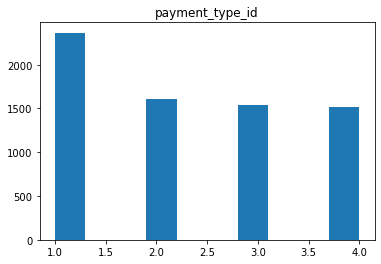

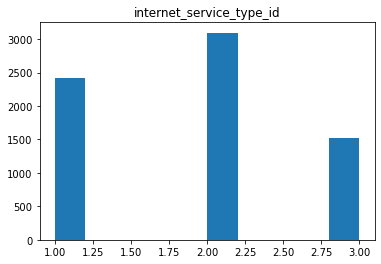

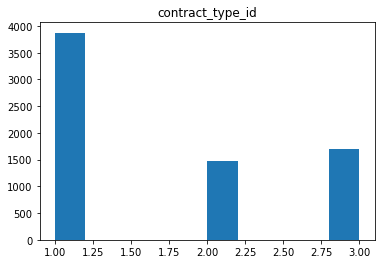

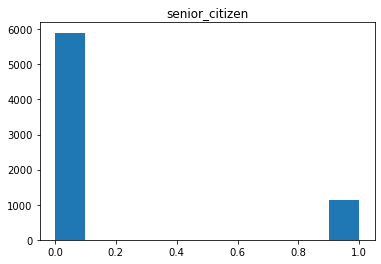

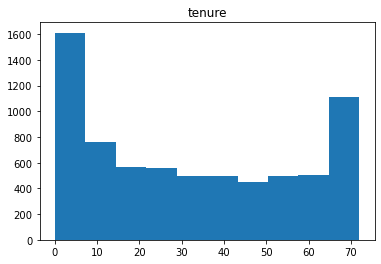

In [4]:
#plot charts on acquired data prior to data cleaning.
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [5]:
#value counts on acquired data prior to data cleaning.
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_type, dtype: float64
----------------------
Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64
Fiber optic    0.439585
DSL            0.343746
None           0.216669
Name: internet_service_type, dtype: float64
----------------------
Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: contract_type, dtype: float64
----------------------
3144-KMTWZ    1
0786-VSSUD    1
3125-RAHBV    1
6862-CQUMB    1
4931-TRZWN    1
             ..
4106-HADHQ    1
4010-YLMVT    1
0459-SPZH

##### TAKEAWAYS 

    -Related services:
        *multiple_services relates to phone_services
        *online_security, online_backup, device_protection, tech_support, streaming_tv, and streaming_movies related to internet services. 

#### From above:
    - From above plot charts and column value counts we find the following have no weight on churn rate and will be dropped:
        - Remove 'phone_service', 'internet_service', 'senior_citizen', 'paperless' & 'tech_support' (irrelevant)

# Clean

    - The prepare file is broke up by sections to identify which stage of the pipeline that I decided to edit, alter, or delete colums, column names, data types, etc...and are identifed by notes within the code.

    * Initial clean up was done just after initial visualization of raw data.
    * all other decisions to modify the dataframe are annotated with the prepare.py module.

In [6]:
#added above to the prepare module.
df = prepare.clean_data(df)
df.head()

,tenure,monthly_charges,fiber,m2m,is_senior,churned,is_male,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,autopayment
0,7,48.20,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
1,1,25.10,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,2,49.25,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0
3,64,81.25,0,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0
4,6,50.35,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0


In [7]:
df.shape

(7043, 18)

In [ ]:
df.info()

In [ ]:
df.fiber.value_counts()

In [ ]:
df.autopayment.value_counts()

# Split your data into train, validate, and test samples.

    The resulting dataframes should be 3 samples:
    
        1. a dataframe for training the algorithms
            * The train dataset is for training our models. We also perform our exploratory data analysis on train.
            
        2. a dataframe for validating the models developed on unseen data
            *First, it is an "out of sample" dataset so that we can evaluate our models on unseen data to measure how well the model generalizes.
            *Second, the validate set allows us to fine tune our hyperparameters.
            
        3. a dataframe for testing the best performing model to ensure the model is able to be generalized on a final set of unseen data not 'overfitting' train, a validate and a test, roughly a 70%:20%:10% split
            *final out of sample dataset used to evaluate how well the models tuned on validate generalize on unseen data.

In [ ]:
#Split the data

train, validate, test = prepare.train_validate_test_split(df, 'churned')
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features.
X_train = train.drop(columns=["churned"])
y_train = train.churned
#*****AND what internet services fiber customers have AND do they affect churn.
X_validate = validate.drop(columns=["churned"])
y_validate = validate.churned

X_test = test.drop(columns=["churned"])
y_test = test.churned

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features.
X_train = train[['fiber','auto_payment']]#features
y_train = train.churned#target

X_validate = validate[['fiber','auto_payment']]
y_validate = validate.churned

X_test = test[['fiber','auto_payment']]
y_test = test.churned

In [ ]:
#Now create the model
model1 = DecisionTreeClassifier(max_depth=3, random_state=123)
#Fit the model
model1.fit(X_train, y_train)
#Use the model
y_predictions = model1.predict(X_train)
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(model1.score(X_train, y_train)))

In [ ]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

# Exploratory

    1. Discover features, using  that have the largest impact on the target variable, i.e. provide the most information gain, drive the outcome. To discover patterns, to spot anomalies, to test hypotheses and to check assumptions
        *The dataframe resulting from these functions should be one that is pre-processed, i.e. ready to be used in modeling.
        *attributes are reduced to features, features are in a numeric form, there are no missing values, and continuous and/or ordered values are scaled to be unitless.
        
    2. Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable).
    
    3. Use visualization techniques to identify drivers and follow up with a statistical test, do so.
    
    4. Test Hypothesis (t-tests, correlation, chi-square, e.g.)

#### Univariate Stats

    1. Descriptive stats, frequencies, histograms. Done during prep and prior to splitting.
    
        * Explore the target variable.

        * Explore the categorical/qualitative variables.

        * Explore the continuous/quantitative variables.

In [ ]:
cat_vars = ['churned','tenure', 'dsl', 'fiber', 'no_internet', 'm2m', 'partner', 'dependents',
            'phone_service', 'tech_support', 'bank_transfer',
           'credit_card', 'e_check', 'check','one_year_contract','two_year_contract',
           'online_security','online_backup','is_male','multiple_lines','device_protection',
           'streaming_tv','streaming_movies','senior_citizen']#'auto_payment',
quant_vars = ['monthly_charges', 'total_charges']

In [ ]:
explore.explore_univariate(train, cat_vars, quant_vars)

##### TAKEAWAYS
    8/28/2021

    - 26.53 (1046) customers churned
    - 54.78 (2160) customers are m2m 
    - Customers with a 'partner' similarly divided (47.6 & 52.6 respectively)
    - Customers with 'dependents' account for 70.1%
    - Customers with 'phone_service_ account' for 91%
    - m2m - 2160 or 55%, 1 year - 811 or 21%, 2 year - 972 or 24%
        *change contract type to m2m (yes or no) and drop one and two year contracts.
        *assumption is that if it is not m2m plan all others are on a contract.
    - payment type - change to autopayment and drop 'credit_card', 'bank_transfer', check' and 'e_check'
    -interent type:
        *change internet type to fiber (Yes or No).
        *Because there was only 61 customers with no internet that churned as validated in the Bivariate stats below.
        *assumption, based on hypothesis, is that a customer is on fiber or not on fiber.
        
    
    
    
________________________________________-



    _Dropped 'gender' almost an equal amout of male and female which will not effect churn rate
    
    _Dropped 'online_security', 'device_protection' - small amount of customers use these services.
    
    _Seems like a large amount of people use 'tech_support' - Is churn rate affected by bad service.
    _Large number of customers use streaming services.
    
    

#### Bivariate Stats

    1. Plot the interaction of each variable with the target. 
    
    2. Document takeaways.

    3. Explore interation of independent variables using viz and/or hypothesis testing to address interdependence.

In [ ]:
cat_vars = cat_vars[1:]

In [ ]:
explore.explore_bivariate(train, 'churned', cat_vars, quant_vars)

##### TAKEAWAYS
    8/28/2021

    - Number of fiber (728)  customers who churned.
       * what is about our fiber internet service is making customers churn?
       * Less people churn on DSL (257) then on fiber...possible validation that fiber service needs work.
       * DROP no_internet. Only 61 customers who do not have internet churn.
       HYPOTHESIS: Customers on fiber are more likely to churn than those customers not on fiber. ****convert Fiber and DSL into one column - Fiber(Yes or No) and encode.
       *****AND what internet services fiber customers have AND do they affect churn.
       * The new fiber becomes a feature
       * test hyp

    - 90.5% of customers in the first month churn than any other month
        HYPOTHESIS: Customers are more than likely to churn in the first month of service than any other customer.
        
    - Between 'partner' and 'dependents' less single (no_d_863-no_p_687=176) customers churn then not single people (p_359 + d_183 = 542).
    
    - senior_citizen:
        HYPOTHESIS: Customers who are NOT senior citizens are more likely to churn than senior citizens.
    
    - Contract type:
        * combine  m2m, 1, and 2 year contracts to a single column titled 'm2m' and encode.
        HYPOTHESIS: m2m churn is greater than those customers not on m2m plan.
        
    - Payment type:
        * convert 'bank_transfer' and 'credit_card' payment into autopayment and DROP 'check' and 'e_chek'
        HYPOTHESIS: Customers enrolled in automatic payment plan are less likely to churn than those customers not enrolled in the automatic payment plan.

    - DROP 'is_male' - it is a 50/50 split
    - DROP 'multiple_lines' similar in churn and not churn
    
    - Phone service:
        HYPOTHESIS: Customers with phone_service (951) are more likely to churn than those that do not have phone_service?
        
    - DROP online_security, online_backup, tech_support and device_protection.

----------------------------------------------
    QUESTIONS:
        1. Why do customers on fiber churn more?
        2. Why do customers churn more in the first month than any other month?
        3. Why do non single customers (with partner or dependents) churn more then single customers?
        4. Why do younger customers churn more than older customers?
        5. Why do customers on m2m plans churn more than those customers on contracts?
        6. Why do customers enrolled in autopayments churn less than those customers not enrolled in an autopayment?
        7. Why do customers churn more with phone services?
        
        * What do these questions all have in common?
       ** What is the cost per month of a younger customers who is not single, has phone services and fiber, on a m2m plan, enrolled in an autopayment plan?
       
       *** FINAL HYPOTHESIS: Customers who are young, not single, on fiber, has phone service, on m2m, and not enrolled in a autopayment plan are more likely to churn than those customers that do not fall in this category.
        
        MY FEATURES: fiber (YES), tenure (1 month), single (NO), senior citizen (NO), m2m (YES), autopayments (NO), phone_service (YES)
        
        Test and validate HYPOTHESIS(reject or fail to reject final hypothesis)
_________________________________________________



    _Churn in one month (213)_
        * Incentive...
            - 1 month free service for m2m customers?
            - Free upgrade service for signing a one_year contract?
            - Free premium service for two year contract?
        * Create a graph that shows churn over tenure.
   
   
    _DROPPED one and two year contract. Numbers have no variance on churn.
    _DROPPED 'multiple_lines' has the similar weight which will not affect churn.
    _Validates drops 'online_security', 'device_protection'
    _DROPPED 'total_charges'. total charges for churn are lower than those who did not churn.
    
    _No partner (687) churn more then couples
    _No dependents (863) churn more than people with dependents.
        * Do singles have an affect on churn? If so, why?
    
    _Lose customers in the first year.
       
       
       
    _Higher number of m2m (929) customers churn.
    
    _Those with phone_service (951) churn.
    
    
    _Customers who do not use 'tech_support' (862) tend to churn.
        * Three options:
            1. Drop column 
            2. Or, keep and recommend to market availability of tech support to customers...
            3. Or is tech support the problem? If so, does tech support need more training.
    
    
    _Customers who are not on auto_payment (780) churn.
    
    _Higher monthly cost have a higher tendency to churn and pay an averge of 74.3 than those who do not 61.85.. Does  higher monthly cost affect churn?
    
    _DROP streaming services. Numbers do not show enough to sway a decision.

#### Multivariate Stats

    1. How subgroups compare to each-other and to the overall population. 
    
    2. Answer questions using visualizations and/or hypothesis testing.
    
    (Here I can test some of my questions...reference Exploratory Analysis

    _ Need to drop some columns for the multivariate stats.

In [ ]:
target = 'churned'
explore.explore_multivariate(train, target, cat_vars, quant_vars)

##### TAKEAWAYS

# Modeling

### Decision Tree

In [ ]:
#create the model

#for classification you can change the algorithm to gini or entropy (information gain).  
#Default is gini.

model = DecisionTreeClassifier(max_depth=1, random_state=123)

In [ ]:
#Fit the model

model = model.fit(X_train, y_train)

#### Make predictions

In [ ]:
#Use the model

# We'll evaluate the model's performance on train, first

y_predictions = model.predict(X_train)
y_predictions = [0:5]

#### Estimate probability

In [ ]:
y_pred_proba = model.predict_proba(X_train)
y_pred_proba[0:5]

#### Compute accuracy

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(model.score(X_train, y_train)))

#### Confusion matrix

TP
TN
FP
FN

In [ ]:
confusion_matrix(y_train, y_pred)

In [ ]:
y_train.value_counts()

In [ ]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)


In [ ]:
print(classification_report(y_train, y_pred))

#### Evaluate the Model with our Validate dataset

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = model.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

In [ ]:
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

### Random Forrest

In [ ]:
#Create the Model
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [ ]:
#Fit the Model
rf.fit(X_train, y_train)

In [ ]:
#Use the Model
#evaluate the weight
print(rf.feature_importances_)

In [ ]:
#estimate
y_pred = rf.predict(X_train)

In [ ]:
#probability
y_pred_proba = rf.predict_proba(X_train)

In [ ]:
#accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))

In [ ]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

In [ ]:
#Create a classificaiton report
print(classification_report(y_train, y_pred))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_validate, y_validate)))

### KNN

In [ ]:
#Create the model
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [ ]:
#fit the model
knn.fit(X_train, y_train)

In [ ]:
#predict/use the model
y_pred = knn.predict(X_train)

In [ ]:
#probability
y_pred_proba = knn.predict_proba(X_train)

In [ ]:
#accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))

In [ ]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
#validate
print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_validate, y_validate)))

# Conclusion

    - What we don't know:
        * How plans relate to cost. i.e. phone to service plans
        * How service plans (online security, online backup, tech support, device protection, and streaming services) relates to cost.
        * Cost of one line, cost of multiple lines (what is multiple lines? Is it 2, 3, 4, or more) and how that relates to cost.